In [4]:
import numpy as np
import pandas as pd
import os
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss
from scipy.interpolate import UnivariateSpline
import statsmodels.api as sm
import matplotlib.pyplot as plt
import collections

pd.set_option("display.max_column", 999)
print(os.listdir("../data/kaggle"))

['march-machine-learning-mania-2023']


# Load the data!

In [5]:
DATA_PATH = '../data/kaggle/march-machine-learning-mania-2024/'


# Data preparation!

In [6]:
"""
tourney_results = pd.read_csv('../input/WNCAATourneyDetailedResults.csv')
seeds = pd.read_csv('../input/WNCAATourneySeeds.csv')
regular_results = pd.read_csv('../input/WRegularSeasonDetailedResults.csv')
"""

tourney_results = pd.concat([
    pd.read_csv(DATA_PATH + "MNCAATourneyDetailedResults.csv"),
    pd.read_csv(DATA_PATH + "WNCAATourneyDetailedResults.csv"),
], ignore_index=True)

seeds = pd.concat([
    pd.read_csv(DATA_PATH + "MNCAATourneySeeds.csv"),
    pd.read_csv(DATA_PATH + "WNCAATourneySeeds.csv"),
], ignore_index=True)

regular_results = pd.concat([
    pd.read_csv(DATA_PATH + "MRegularSeasonDetailedResults.csv"),
    pd.read_csv(DATA_PATH + "WRegularSeasonDetailedResults.csv"),
], ignore_index=True)

def prepare_data(df):
    dfswap = df[['Season', 'DayNum', 'LTeamID', 'LScore', 'WTeamID', 'WScore', 'WLoc', 'NumOT', 
    'LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF', 
    'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR', 'WAst', 'WTO', 'WStl', 'WBlk', 'WPF']]

    dfswap.loc[df['WLoc'] == 'H', 'WLoc'] = 'A'
    dfswap.loc[df['WLoc'] == 'A', 'WLoc'] = 'H'
    df.columns.values[6] = 'location'
    dfswap.columns.values[6] = 'location'    
      
    df.columns = [x.replace('W','T1_').replace('L','T2_') for x in list(df.columns)]
    dfswap.columns = [x.replace('L','T1_').replace('W','T2_') for x in list(dfswap.columns)]

    output = pd.concat([df, dfswap]).reset_index(drop=True)
    output.loc[output.location=='N','location'] = '0'
    output.loc[output.location=='H','location'] = '1'
    output.loc[output.location=='A','location'] = '-1'
    output.location = output.location.astype(int)
    
    output['PointDiff'] = output['T1_Score'] - output['T2_Score']
    
    return output

In [7]:
regular_data = prepare_data(regular_results)
tourney_data = prepare_data(tourney_results)

# Feature engineering!

In [8]:
boxscore_cols = ['T1_Score', 'T2_Score', 
        'T1_FGM', 'T1_FGA', 'T1_FGM3', 'T1_FGA3', 'T1_FTM', 'T1_FTA', 'T1_OR', 'T1_DR', 'T1_Ast', 'T1_TO', 'T1_Stl', 'T1_Blk', 'T1_PF', 
        'T2_FGM', 'T2_FGA', 'T2_FGM3', 'T2_FGA3', 'T2_FTM', 'T2_FTA', 'T2_OR', 'T2_DR', 'T2_Ast', 'T2_TO', 'T2_Stl', 'T2_Blk', 'T2_PF', 
        'PointDiff']

boxscore_cols = [
        'T1_FGM', 'T1_FGA', 'T1_FGM3', 'T1_FGA3', 'T1_OR', 'T1_Ast', 'T1_TO', 'T1_Stl', 'T1_PF', 
        'T2_FGM', 'T2_FGA', 'T2_FGM3', 'T2_FGA3', 'T2_OR', 'T2_Ast', 'T2_TO', 'T2_Stl', 'T2_Blk',  
        'PointDiff']

funcs = [np.mean]

In [9]:
season_statistics = regular_data.groupby(["Season", 'T1_TeamID'])[boxscore_cols].agg(funcs)


C:\Users\charl\AppData\Local\Temp\ipykernel_15532\1749545009.py:1: FutureWarning: The provided callable <function mean at 0x000001D1C7B69EA0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  season_statistics = regular_data.groupby(["Season", 'T1_TeamID'])[boxscore_cols].agg(funcs)


In [10]:
season_statistics = regular_data.groupby(["Season", 'T1_TeamID'])[boxscore_cols].agg(funcs).reset_index()

C:\Users\charl\AppData\Local\Temp\ipykernel_15532\1896935453.py:1: FutureWarning: The provided callable <function mean at 0x000001D1C7B69EA0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  season_statistics = regular_data.groupby(["Season", 'T1_TeamID'])[boxscore_cols].agg(funcs).reset_index()


In [11]:
season_statistics.columns = [''.join(col).strip() for col in season_statistics.columns.values]

In [12]:
season_statistics_T1 = season_statistics.copy()
season_statistics_T2 = season_statistics.copy()

season_statistics_T1.columns = ["T1_" + x.replace("T1_","").replace("T2_","opponent_") for x in list(season_statistics_T1.columns)]
season_statistics_T2.columns = ["T2_" + x.replace("T1_","").replace("T2_","opponent_") for x in list(season_statistics_T2.columns)]
season_statistics_T1.columns.values[0] = "Season"
season_statistics_T2.columns.values[0] = "Season"

In [13]:
tourney_data = tourney_data[['Season', 'DayNum', 'T1_TeamID', 'T1_Score', 'T2_TeamID' ,'T2_Score']]

In [14]:
tourney_data = pd.merge(tourney_data, season_statistics_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, season_statistics_T2, on = ['Season', 'T2_TeamID'], how = 'left')

In [15]:
last14days_stats_T1 = regular_data.loc[regular_data.DayNum>118].reset_index(drop=True)
last14days_stats_T1['win'] = np.where(last14days_stats_T1['PointDiff']>0,1,0)
last14days_stats_T1 = last14days_stats_T1.groupby(['Season','T1_TeamID'])['win'].mean().reset_index(name='T1_win_ratio_14d')

last14days_stats_T2 = regular_data.loc[regular_data.DayNum>118].reset_index(drop=True)
last14days_stats_T2['win'] = np.where(last14days_stats_T2['PointDiff']<0,1,0)
last14days_stats_T2 = last14days_stats_T2.groupby(['Season','T2_TeamID'])['win'].mean().reset_index(name='T2_win_ratio_14d')

In [16]:
tourney_data = pd.merge(tourney_data, last14days_stats_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, last14days_stats_T2, on = ['Season', 'T2_TeamID'], how = 'left')

In [17]:
regular_season_effects = regular_data[['Season','T1_TeamID','T2_TeamID','PointDiff']].copy()
regular_season_effects['T1_TeamID'] = regular_season_effects['T1_TeamID'].astype(str)
regular_season_effects['T2_TeamID'] = regular_season_effects['T2_TeamID'].astype(str)
regular_season_effects['win'] = np.where(regular_season_effects['PointDiff']>0,1,0)
march_madness = pd.merge(seeds[['Season','TeamID']],seeds[['Season','TeamID']],on='Season')
march_madness.columns = ['Season', 'T1_TeamID', 'T2_TeamID']
march_madness.T1_TeamID = march_madness.T1_TeamID.astype(str)
march_madness.T2_TeamID = march_madness.T2_TeamID.astype(str)
regular_season_effects = pd.merge(regular_season_effects, march_madness, on = ['Season','T1_TeamID','T2_TeamID'])
regular_season_effects.shape

(19014, 5)

In [18]:
def team_quality(season):
    formula = 'win~-1+T1_TeamID+T2_TeamID'
    glm = sm.GLM.from_formula(formula=formula, 
                              data=regular_season_effects.loc[regular_season_effects.Season==season,:], 
                              family=sm.families.Binomial()).fit()
    
    quality = pd.DataFrame(glm.params).reset_index()
    quality.columns = ['TeamID','quality']
    quality['Season'] = season
    #quality['quality'] = np.exp(quality['quality'])
    quality = quality.loc[quality.TeamID.str.contains('T1_')].reset_index(drop=True)
    quality['TeamID'] = quality['TeamID'].apply(lambda x: x[10:14]).astype(int)
    return quality

In [19]:
formula = 'win~-1+T1_TeamID+T2_TeamID'
glm = sm.GLM.from_formula(formula=formula, 
                          data=regular_season_effects.loc[regular_season_effects.Season==2010,:], 
                          family=sm.families.Binomial()).fit()

quality = pd.DataFrame(glm.params).reset_index()

c:\Users\charl\Desktop\Git\tep-research\.venv\lib\site-packages\statsmodels\genmod\families\links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


In [20]:
glm_quality = pd.concat([team_quality(2010),
                         team_quality(2011),
                         team_quality(2012),
                         team_quality(2013),
                         team_quality(2014),
                         team_quality(2015),
                         team_quality(2016),
                         team_quality(2017),
                         team_quality(2018),
                         team_quality(2019),
                         ##team_quality(2020),
                         team_quality(2021),
                         team_quality(2022),
                         team_quality(2023)
                         ]).reset_index(drop=True)

c:\Users\charl\Desktop\Git\tep-research\.venv\lib\site-packages\statsmodels\genmod\families\links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
c:\Users\charl\Desktop\Git\tep-research\.venv\lib\site-packages\statsmodels\genmod\families\links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
c:\Users\charl\Desktop\Git\tep-research\.venv\lib\site-packages\statsmodels\genmod\families\links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
c:\Users\charl\Desktop\Git\tep-research\.venv\lib\site-packages\statsmodels\genmod\families\links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
c:\Users\charl\Desktop\Git\tep-research\.venv\lib\site-packages\statsmodels\genmod\families\links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
c:\Users\charl\Desktop\Git\tep-research\.venv\lib\site-packages\statsmodels\genmod\families\links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z

In [21]:
glm_quality_T1 = glm_quality.copy()
glm_quality_T2 = glm_quality.copy()
glm_quality_T1.columns = ['T1_TeamID','T1_quality','Season']
glm_quality_T2.columns = ['T2_TeamID','T2_quality','Season']

In [22]:
tourney_data = pd.merge(tourney_data, glm_quality_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, glm_quality_T2, on = ['Season', 'T2_TeamID'], how = 'left')

In [23]:
seeds['seed'] = seeds['Seed'].apply(lambda x: int(x[1:3]))

In [24]:
seeds_T1 = seeds[['Season','TeamID','seed']].copy()
seeds_T2 = seeds[['Season','TeamID','seed']].copy()
seeds_T1.columns = ['Season','T1_TeamID','T1_seed']
seeds_T2.columns = ['Season','T2_TeamID','T2_seed']

In [25]:
tourney_data = pd.merge(tourney_data, seeds_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, seeds_T2, on = ['Season', 'T2_TeamID'], how = 'left')

In [26]:
tourney_data["Seed_diff"] = tourney_data["T1_seed"] - tourney_data["T2_seed"]

# Time to build some models!

In [27]:
y = tourney_data['T1_Score'] - tourney_data['T2_Score']

In [28]:
features = list(season_statistics_T1.columns[2:999]) + \
    list(season_statistics_T2.columns[2:999]) + \
    list(seeds_T1.columns[2:999]) + \
    list(seeds_T2.columns[2:999]) + \
    list(last14days_stats_T1.columns[2:999]) + \
    list(last14days_stats_T2.columns[2:999]) + \
    ["Seed_diff"] + ["T1_quality","T2_quality"]

len(features)

45

In [29]:
X = tourney_data[features].values
dtrain = xgb.DMatrix(X, label = y)

In [30]:
def cauchyobj(preds, dtrain):
    labels = dtrain.get_label()
    c = 5000 
    x =  preds-labels    
    grad = x / (x**2/c**2+1)
    hess = -c**2*(x**2-c**2)/(x**2+c**2)**2
    return grad, hess

In [53]:
param = {} 
#param['objective'] = 'reg:linear'
param['eval_metric'] =  'mae'
param['booster'] = 'gbtree'
param['eta'] = 0.05 #change to ~0.02 for final run
param['subsample'] = 0.35
param['colsample_bytree'] = 0.7
param['num_parallel_tree'] = 3 #recommend 10
param['min_child_weight'] = 40
param['gamma'] = 10
param['max_depth'] =  3
param['silent'] = 1

print(param)

{'eval_metric': 'mae', 'booster': 'gbtree', 'eta': 0.05, 'subsample': 0.35, 'colsample_bytree': 0.7, 'num_parallel_tree': 3, 'min_child_weight': 40, 'gamma': 10, 'max_depth': 3, 'silent': 1}


In [54]:
xgb_cv = []
repeat_cv = 3 # recommend 10

for i in range(repeat_cv): 
    print(f"Fold repeater {i}")
    xgb_cv.append(
        xgb.cv(
          params = param,
          dtrain = dtrain,
          obj = cauchyobj,
          num_boost_round = 3000,
          folds = KFold(n_splits = 5, shuffle = True, random_state = i),
          early_stopping_rounds = 25,
          verbose_eval = 50
        )
    )

Fold repeater 0
[0]	train-mae:13.37932+0.06439	test-mae:13.38273+0.26215


c:\Users\charl\Desktop\Git\tep-research\.venv\lib\site-packages\xgboost\core.py:160: UserWarning: [16:21:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[50]	train-mae:9.43751+0.05063	test-mae:9.73323+0.19395
[100]	train-mae:9.02952+0.04891	test-mae:9.55743+0.18740
[150]	train-mae:8.77093+0.04495	test-mae:9.52324+0.17952
[200]	train-mae:8.56051+0.04006	test-mae:9.51776+0.15628
[230]	train-mae:8.44910+0.03982	test-mae:9.51757+0.14885
Fold repeater 1
[0]	train-mae:13.37960+0.01976	test-mae:13.38961+0.06895


c:\Users\charl\Desktop\Git\tep-research\.venv\lib\site-packages\xgboost\core.py:160: UserWarning: [16:21:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[50]	train-mae:9.45485+0.06428	test-mae:9.72103+0.19615
[100]	train-mae:9.04850+0.05449	test-mae:9.55304+0.19352
[150]	train-mae:8.79033+0.04516	test-mae:9.51759+0.16778
[200]	train-mae:8.56702+0.04045	test-mae:9.50552+0.16955
[250]	train-mae:8.37800+0.04660	test-mae:9.49347+0.15516
[297]	train-mae:8.21131+0.05134	test-mae:9.49917+0.14263
Fold repeater 2
[0]	train-mae:13.38274+0.09007	test-mae:13.39137+0.36113


c:\Users\charl\Desktop\Git\tep-research\.venv\lib\site-packages\xgboost\core.py:160: UserWarning: [16:21:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[50]	train-mae:9.45181+0.04325	test-mae:9.73215+0.19112
[100]	train-mae:9.04909+0.03362	test-mae:9.56491+0.14973
[150]	train-mae:8.79671+0.03509	test-mae:9.54103+0.14115
[200]	train-mae:8.57631+0.03877	test-mae:9.52869+0.14906
[250]	train-mae:8.37711+0.04667	test-mae:9.52348+0.15159
[256]	train-mae:8.35660+0.04554	test-mae:9.52623+0.14967


In [55]:
iteration_counts = [np.argmin(x['test-mae-mean'].values) for x in xgb_cv]
val_mae = [np.min(x['test-mae-mean'].values) for x in xgb_cv]
iteration_counts, val_mae

([205, 272, 231], [9.516655404767594, 9.491125961746414, 9.518783521199804])

In [56]:
oof_preds = []
for i in range(repeat_cv):
    print(f"Fold repeater {i}")
    preds = y.copy()
    kfold = KFold(n_splits = 5, shuffle = True, random_state = i)    
    for train_index, val_index in kfold.split(X,y):
        dtrain_i = xgb.DMatrix(X[train_index], label = y[train_index])
        dval_i = xgb.DMatrix(X[val_index], label = y[val_index])  
        model = xgb.train(
              params = param,
              dtrain = dtrain_i,
              num_boost_round = iteration_counts[i],
              verbose_eval = 50
        )
        preds[val_index] = model.predict(dval_i)
    oof_preds.append(np.clip(preds,-30,30))

Fold repeater 0


c:\Users\charl\Desktop\Git\tep-research\.venv\lib\site-packages\xgboost\core.py:160: UserWarning: [16:21:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\charl\AppData\Local\Temp\ipykernel_15532\4087228217.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 2.14611206e+01  1.43442190e+00  1.13013372e+01  1.27504377e+01
 -8.83305168e+00  1.12344894e+01  3.97223324e-01  2.25653267e+01
  9.95929813e+00 -8.91440749e-01  1.13067722e+01  7.98600149e+00
 -9.42383385e+00 -2.84536123e+00  6.70881081e+00  1.05073607e+00
  2.01677189e+01 -2.79806685e+00  8.15390015e+00  5.27731991e+00
  1.76988411e+01  1.44486246e+01  3.26608133e+00  2.80190158e+00
  1.18759632e+00  2.05772018e+01  2.85630932e+01  1.02904749e+01
 -7.82860458e-01  6

Fold repeater 1


c:\Users\charl\Desktop\Git\tep-research\.venv\lib\site-packages\xgboost\core.py:160: UserWarning: [16:21:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\charl\AppData\Local\Temp\ipykernel_15532\4087228217.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 1.77537861e+01 -1.07574539e+01  1.19356894e+00  1.90149441e+01
 -2.12676215e+00  3.61973691e+00  2.18156490e+01 -2.87311983e+00
  2.02115612e+01  1.73430290e+01  2.60783386e+00  1.08408747e+01
 -1.74183118e+00  2.85537815e+00 -3.29497904e-02 -1.61216855e+00
  2.27582512e+01  6.72923231e+00  1.22021856e+01  1.48900604e+01
  1.78499393e+01  3.22281241e+00  3.12482095e+00  5.58625841e+00
  6.48510313e+00  1.60572159e+00  5.61936045e+00  4.61369276e+00
 -7.34220982e+00  5

Fold repeater 2


c:\Users\charl\Desktop\Git\tep-research\.venv\lib\site-packages\xgboost\core.py:160: UserWarning: [16:21:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\charl\AppData\Local\Temp\ipykernel_15532\4087228217.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 2.27930516e-01 -8.64626789e+00 -6.03047228e+00 -1.94384706e+00
  6.41654730e+00 -3.20648527e+00 -1.24798656e+00 -3.43013573e+00
 -1.54938865e+00  2.36461582e+01  1.01224365e+01 -1.66770494e+00
  2.55486336e+01  2.40202122e+01  1.84547400e+00  1.46351843e+01
  8.74273396e+00 -7.20636606e+00  1.26676679e+00  3.57170725e+00
  5.15695763e+00 -2.76137412e-01  2.90880585e+00  6.73173952e+00
 -6.97424555e+00 -4.12276506e+00  3.11454797e+00  7.14073086e+00
  1.04524240e-01  3

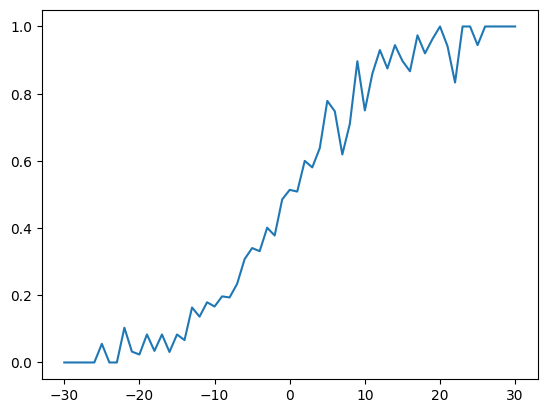

In [57]:
plot_df = pd.DataFrame({"pred":oof_preds[0], "label":np.where(y>0,1,0)})
plot_df["pred_int"] = plot_df["pred"].astype(int)
plot_df = plot_df.groupby('pred_int')['label'].mean().reset_index(name='average_win_pct')

plt.figure()
plt.plot(plot_df.pred_int,plot_df.average_win_pct)

In [58]:
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
        
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    
    print(f"logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 

logloss of cvsplit 0: 0.5151192798217691
logloss of cvsplit 1: 0.5159912789683784
logloss of cvsplit 2: 0.5160093519545259


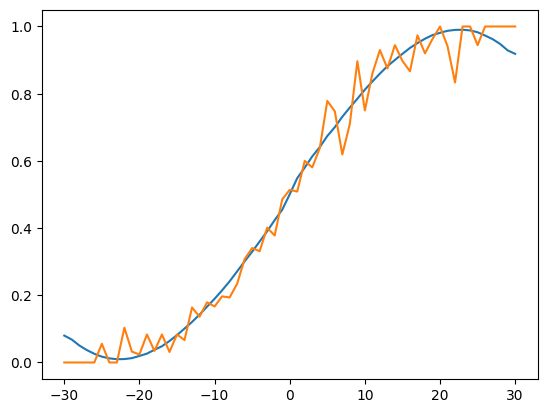

In [59]:
plot_df = pd.DataFrame({"pred":oof_preds[0], "label":np.where(y>0,1,0), "spline":spline_model[0](oof_preds[0])})
plot_df["pred_int"] = (plot_df["pred"]).astype(int)
plot_df = plot_df.groupby('pred_int')[['spline','label']].mean().reset_index()

plt.figure()
plt.plot(plot_df.pred_int,plot_df.spline)
plt.plot(plot_df.pred_int,plot_df.label)

In [60]:
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    spline_fit = np.clip(spline_fit,0.025,0.975)
    
    print(f"adjusted logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 

adjusted logloss of cvsplit 0: 0.5136461896428316
adjusted logloss of cvsplit 1: 0.5152295098210787
adjusted logloss of cvsplit 2: 0.514042976871571


In [61]:
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    spline_fit = np.clip(spline_fit,0.025,0.975)
    spline_fit[(tourney_data.T1_seed==1) & (tourney_data.T2_seed==16)] = 1.0
    spline_fit[(tourney_data.T1_seed==2) & (tourney_data.T2_seed==15)] = 1.0
    spline_fit[(tourney_data.T1_seed==3) & (tourney_data.T2_seed==14)] = 1.0
    spline_fit[(tourney_data.T1_seed==4) & (tourney_data.T2_seed==13)] = 1.0
    spline_fit[(tourney_data.T1_seed==16) & (tourney_data.T2_seed==1)] = 0.0
    spline_fit[(tourney_data.T1_seed==15) & (tourney_data.T2_seed==2)] = 0.0
    spline_fit[(tourney_data.T1_seed==14) & (tourney_data.T2_seed==3)] = 0.0
    spline_fit[(tourney_data.T1_seed==13) & (tourney_data.T2_seed==4)] = 0.0
    
    print(f"adjusted logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 

adjusted logloss of cvsplit 0: 1.0652532895876634
adjusted logloss of cvsplit 1: 1.0662612926759245
adjusted logloss of cvsplit 2: 1.0656553336601258


In [62]:
#looking for upsets
pd.concat(
    [tourney_data[(tourney_data.T1_seed==1) & (tourney_data.T2_seed==16) & (tourney_data.T1_Score < tourney_data.T2_Score)],
     tourney_data[(tourney_data.T1_seed==2) & (tourney_data.T2_seed==15) & (tourney_data.T1_Score < tourney_data.T2_Score)],
     tourney_data[(tourney_data.T1_seed==3) & (tourney_data.T2_seed==14) & (tourney_data.T1_Score < tourney_data.T2_Score)],
     tourney_data[(tourney_data.T1_seed==4) & (tourney_data.T2_seed==13) & (tourney_data.T1_Score < tourney_data.T2_Score)],
     tourney_data[(tourney_data.T1_seed==16) & (tourney_data.T2_seed==1) & (tourney_data.T1_Score > tourney_data.T2_Score)],
     tourney_data[(tourney_data.T1_seed==15) & (tourney_data.T2_seed==2) & (tourney_data.T1_Score > tourney_data.T2_Score)],
     tourney_data[(tourney_data.T1_seed==14) & (tourney_data.T2_seed==3) & (tourney_data.T1_Score > tourney_data.T2_Score)],
     tourney_data[(tourney_data.T1_seed==13) & (tourney_data.T2_seed==4) & (tourney_data.T1_Score > tourney_data.T2_Score)]]
)   

#https://en.wikipedia.org/wiki/NCAA_Division_I_Women%27s_Basketball_Tournament_upsets

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_ORmean,T1_Astmean,T1_TOmean,T1_Stlmean,T1_PFmean,T1_opponent_FGMmean,T1_opponent_FGAmean,T1_opponent_FGM3mean,T1_opponent_FGA3mean,T1_opponent_ORmean,T1_opponent_Astmean,T1_opponent_TOmean,T1_opponent_Stlmean,T1_opponent_Blkmean,T1_PointDiffmean,T2_FGMmean,T2_FGAmean,T2_FGM3mean,T2_FGA3mean,T2_ORmean,T2_Astmean,T2_TOmean,T2_Stlmean,T2_PFmean,T2_opponent_FGMmean,T2_opponent_FGAmean,T2_opponent_FGM3mean,T2_opponent_FGA3mean,T2_opponent_ORmean,T2_opponent_Astmean,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_PointDiffmean,T1_win_ratio_14d,T2_win_ratio_14d,T1_quality,T2_quality,T1_seed,T2_seed,Seed_diff
3022,2018,137,1438,54,1420,74,25.000000,54.181818,7.363636,18.878788,8.393939,13.727273,8.575758,6.787879,14.060606,18.818182,50.151515,6.151515,20.303030,8.393939,8.848485,12.727273,3.878788,2.636364,14.151515,25.612903,58.451613,9.838710,25.774194,9.709677,14.870968,11.677419,7.387097,16.516129,25.322581,56.612903,8.322581,23.161290,9.935484,13.580645,14.322581,6.258065,2.806452,1.516129,1.000000,1.000000,2.311823e+15,-4.078100e+15,1,16,-15
2613,2012,137,1181,70,1250,75,25.757576,56.272727,8.121212,21.606061,11.909091,12.454545,12.181818,6.242424,18.181818,25.515152,58.909091,4.454545,14.060606,11.696970,11.151515,12.909091,5.666667,2.666667,9.060606,25.750000,57.812500,7.406250,20.875000,10.843750,13.000000,11.531250,7.812500,17.781250,23.187500,55.562500,5.968750,17.906250,10.218750,13.062500,14.687500,5.687500,3.843750,10.218750,0.500000,1.000000,9.363674e+14,-2.494425e+15,2,15,-13
2616,2012,137,1281,84,1313,86,28.000000,55.588235,8.235294,20.823529,9.176471,16.205882,10.294118,8.205882,14.117647,24.617647,55.794118,6.235294,17.205882,10.764706,12.823529,14.411765,5.264706,2.647059,14.558824,24.312500,54.281250,5.343750,17.031250,11.187500,12.000000,14.812500,6.531250,19.093750,23.375000,57.687500,5.625000,18.468750,12.281250,11.093750,13.656250,6.593750,3.125000,2.812500,1.000000,1.000000,8.424736e+14,-4.350357e+15,2,15,-13
2676,2013,137,1207,68,1195,78,23.000000,50.419355,5.870968,16.419355,9.225806,14.806452,12.677419,7.548387,16.870968,19.419355,51.612903,5.354839,17.580645,10.806452,10.903226,14.225806,6.354839,3.290323,8.838710,26.218750,57.500000,6.625000,20.031250,11.687500,13.718750,14.656250,8.812500,17.593750,23.625000,57.468750,6.875000,21.843750,12.000000,13.281250,15.656250,6.937500,3.031250,5.031250,0.500000,1.000000,-1.498659e+15,-3.184150e+15,2,15,-13
2878,2016,137,1277,81,1292,90,28.794118,59.529412,9.117647,21.029412,12.294118,20.558824,11.794118,4.411765,19.088235,21.794118,57.823529,5.676471,18.794118,9.352941,10.617647,9.558824,5.323529,3.235294,16.382353,25.903226,57.709677,8.000000,20.580645,10.258065,13.032258,11.935484,6.258065,20.451613,23.225806,54.322581,6.258065,18.354839,9.064516,11.451613,13.516129,5.838710,2.774194,4.096774,1.000000,1.000000,2.764795e+15,-8.070986e+15,2,15,-13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1079,2019,137,1414,70,1243,64,26.941176,58.970588,6.794118,18.882353,11.647059,13.235294,11.529412,5.500000,18.500000,21.852941,57.176471,6.235294,18.705882,10.264706,9.382353,11.205882,5.088235,2.735294,8.852941,23.757576,55.121212,7.060606,21.030303,9.454545,13.757576,11.272727,7.606061,16.151515,21.060606,50.848485,6.787879,21.757576,8.212121,11.545455,14.848485,6.181818,2.848485,6.575758,1.000000,0.750000,2.154893e+15,3.733654e+15,13,4,9
1125,2021,137,1317,78,1345,69,25.080000,53.280000,7.400000,19.840000,7.280000,13.040000,12.560000,6.840000,5.520000,21.320000,52.920000,5.720000,18.120000,7.720000,9.160000,13.520000,6.480000,2.960000,7.640000,25.518519,56.555556,7.111111,21.222222,9.666667,14.296296,11.888889,5.185185,4.481481,23.333333,56.333333,8.111111,25.740741,7.407407,14.074074,10.703704,5.5

In [63]:
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    spline_fit = np.clip(spline_fit,0.025,0.975)
    spline_fit[(tourney_data.T1_seed==1) & (tourney_data.T2_seed==16) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==2) & (tourney_data.T2_seed==15) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==3) & (tourney_data.T2_seed==14) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==4) & (tourney_data.T2_seed==13) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==16) & (tourney_data.T2_seed==1) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    spline_fit[(tourney_data.T1_seed==15) & (tourney_data.T2_seed==2) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    spline_fit[(tourney_data.T1_seed==14) & (tourney_data.T2_seed==3) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    spline_fit[(tourney_data.T1_seed==13) & (tourney_data.T2_seed==4) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    
    print(f"adjusted logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 

adjusted logloss of cvsplit 0: 0.4891807132554755
adjusted logloss of cvsplit 1: 0.48985279643043744
adjusted logloss of cvsplit 2: 0.4895416264192113


In [64]:
val_cv = []
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    spline_fit = np.clip(spline_fit,0.025,0.975)
    spline_fit[(tourney_data.T1_seed==1) & (tourney_data.T2_seed==16) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==2) & (tourney_data.T2_seed==15) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==3) & (tourney_data.T2_seed==14) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==4) & (tourney_data.T2_seed==13) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==16) & (tourney_data.T2_seed==1) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    spline_fit[(tourney_data.T1_seed==15) & (tourney_data.T2_seed==2) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    spline_fit[(tourney_data.T1_seed==14) & (tourney_data.T2_seed==3) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    spline_fit[(tourney_data.T1_seed==13) & (tourney_data.T2_seed==4) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    
    val_cv.append(pd.DataFrame({"y":np.where(y>0,1,0), "pred":spline_fit, "season":tourney_data.Season}))
    print(f"adjusted logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 
    
val_cv = pd.concat(val_cv)
val_cv.groupby('season').apply(lambda x: log_loss(x.y, x.pred))

adjusted logloss of cvsplit 0: 0.4891807132554755
adjusted logloss of cvsplit 1: 0.48985279643043744
adjusted logloss of cvsplit 2: 0.4895416264192113


C:\Users\charl\AppData\Local\Temp\ipykernel_15532\1651078057.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  val_cv.groupby('season').apply(lambda x: log_loss(x.y, x.pred))


season
2003    0.515709
2004    0.484610
2005    0.480826
2006    0.550376
2007    0.421372
2008    0.458217
2009    0.461486
2010    0.468817
2011    0.478980
2012    0.487567
2013    0.506643
2014    0.484550
2015    0.418824
2016    0.545876
2017    0.482308
2018    0.534358
2019    0.431352
2021    0.518610
2022    0.541196
dtype: float64

# Submission time!

In [65]:
"""
sub["Season"] = 2018
sub["T1_TeamID"] = sub["ID"].apply(lambda x: x[5:9]).astype(int)
sub["T2_TeamID"] = sub["ID"].apply(lambda x: x[10:14]).astype(int)
sub.head()
"""
sub = pd.read_csv(DATA_PATH + "SampleSubmission2023.csv")
sub['Season'] = sub['ID'].apply(lambda x: int(x.split('_')[0]))
sub["T1_TeamID"] = sub['ID'].apply(lambda x: int(x.split('_')[1]))
sub["T2_TeamID"] = sub['ID'].apply(lambda x: int(x.split('_')[2]))
sub.head()


,ID,Pred,Season,T1_TeamID,T2_TeamID
0,2023_1101_1102,0.5,2023,1101,1102
1,2023_1101_1103,0.5,2023,1101,1103
2,2023_1101_1104,0.5,2023,1101,1104
3,2023_1101_1105,0.5,2023,1101,1105
4,2023_1101_1106,0.5,2023,1101,1106


In [66]:
sub = pd.merge(sub, season_statistics_T1, on = ['Season', 'T1_TeamID'], how = 'left')
sub = pd.merge(sub, season_statistics_T2, on = ['Season', 'T2_TeamID'], how = 'left')

sub = pd.merge(sub, glm_quality_T1, on = ['Season', 'T1_TeamID'], how = 'left')

sub = pd.merge(sub, glm_quality_T2, on = ['Season', 'T2_TeamID'], how = 'left')

sub = pd.merge(sub, seeds_T1, on = ['Season', 'T1_TeamID'], how = 'left')
sub = pd.merge(sub, seeds_T2, on = ['Season', 'T2_TeamID'], how = 'left')
sub = pd.merge(sub, last14days_stats_T1, on = ['Season', 'T1_TeamID'], how = 'left')
sub = pd.merge(sub, last14days_stats_T2, on = ['Season', 'T2_TeamID'], how = 'left')

sub["Seed_diff"] = sub["T1_seed"] - sub["T2_seed"]

sub.head()

,ID,Pred,Season,T1_TeamID,T2_TeamID,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_ORmean,T1_Astmean,T1_TOmean,T1_Stlmean,T1_PFmean,T1_opponent_FGMmean,T1_opponent_FGAmean,T1_opponent_FGM3mean,T1_opponent_FGA3mean,T1_opponent_ORmean,T1_opponent_Astmean,T1_opponent_TOmean,T1_opponent_Stlmean,T1_opponent_Blkmean,T1_PointDiffmean,T2_FGMmean,T2_FGAmean,T2_FGM3mean,T2_FGA3mean,T2_ORmean,T2_Astmean,T2_TOmean,T2_Stlmean,T2_PFmean,T2_opponent_FGMmean,T2_opponent_FGAmean,T2_opponent_FGM3mean,T2_opponent_FGA3mean,T2_opponent_ORmean,T2_opponent_Astmean,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_PointDiffmean,T1_quality,T2_quality,T1_seed,T2_seed,T1_win_ratio_14d,T2_win_ratio_14d,Seed_diff
0,2023_1101_1102,0.5,2023,1101,1102,25.384615,58.346154,6.692308,19.5,7.615385,14.769231,11.846154,7.961538,20.884615,25.807692,51.423077,6.576923,17.269231,7.346154,13.538462,15.769231,5.384615,3.192308,-3.692308,23.625000,51.125000,8.156250,22.906250,5.625000,15.312500,10.906250,5.750000,17.000000,23.875000,53.687500,5.187500,17.687500,7.937500,10.093750,10.687500,5.718750,3.093750,-0.125000,NaN,NaN,NaN,NaN,0.0,0.0,NaN
1,2023_1101_1103,0.5,2023,1101,1103,25.384615,58.346154,6.692308,19.5,7.615385,14.769231,11.846154,7.961538,20.884615,25.807692,51.423077,6.576923,17.269231,7.346154,13.538462,15.769231,5.384615,3.192308,-3.692308,25.387097,57.451613,8.806452,25.193548,8.387097,13.000000,10.838710,5.774194,16.193548,24.709677,56.806452,7.064516,20.096774,7.322581,11.483871,11.322581,5.709677,3.032258,5.838710,NaN,NaN,NaN,NaN,0.0,0.5,NaN
2,2023_1101_1104,0.5,2023,1101,1104,25.384615,58.346154,6.692308,19.5,7.615385,14.769231,11.846154,7.961538,20.884615,25.807692,51.423077,6.576923,17.269231,7.346154,13.538462,15.769231,5.384615,3.192308,-3.692308,27.764706,62.205882,10.058824,29.764706,11.264706,15.205882,13.588235,6.058824,18.617647,23.941176,64.382353,5.529412,19.705882,9.500000,10.000000,11.411765,7.294118,3.705882,13.676471,NaN,-7.979282e+13,NaN,1.0,0.0,0.8,NaN
3,2023_1101_1105,0.5,2023,1101,1105,25.384615,58.346154,6.692308,19.5,7.615385,14.769231,11.846154,7.961538,20.884615,25.807692,51.423077,6.576923,17.269231,7.346154,13.538462,15.769231,5.384615,3.192308,-3.692308,24.233333,56.500000,6.400000,18.466667,8.766667,12.066667,13.733333,7.500000,19.100000,23.600000,55.300000,7.466667,22.066667,9.966667,12.600000,14.166667,7.500000,3.700000,-3.066667,NaN,NaN,NaN,NaN,0.0,0.5,NaN
4,2023_1101_1106,0.5,2023,1101,1106,25.384615,58.346154,6.692308,19.5,7.615385,14.769231,11.846154,7.961538,20.884615,25.807692,51.423077,6.576923,17.269231,7.346154,13.538462,15.769231,5.384615,3.192308,-3.692308,21.800000,58.566667,5.966667,19.400000,10.300000,9.733333,12.300000,5.666667,17.866667,25.733333,58.800000,6.966667,20.400000,10.633333,11.833333,11.266667,6.733333,4.833333,-10.033333,NaN,NaN,NaN,NaN,0.0,0.0,NaN


In [67]:
Xsub = sub[features].values
dtest = xgb.DMatrix(Xsub)

In [68]:
sub_models = []
for i in range(repeat_cv):
    print(f"Fold repeater {i}")
    sub_models.append(
        xgb.train(
          params = param,
          dtrain = dtrain,
          num_boost_round = int(iteration_counts[i] * 1.05),
          verbose_eval = 50
        )
    )

Fold repeater 0


c:\Users\charl\Desktop\Git\tep-research\.venv\lib\site-packages\xgboost\core.py:160: UserWarning: [16:21:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


Fold repeater 1
Fold repeater 2


c:\Users\charl\Desktop\Git\tep-research\.venv\lib\site-packages\xgboost\core.py:160: UserWarning: [16:21:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


In [69]:

booster = sub_models[0]

feature_importance = booster.get_score(importance_type='weight')
mapped_feature_importance = {features[int(key[1:])]: value for key, value in feature_importance.items()}

# Display the mapped feature importance
importances = pd.DataFrame([mapped_feature_importance]).T.reset_index().rename(columns={0:'score','index':'col'})
importances.sort_values('score', ascending=False)

,col,score
42,Seed_diff,252.0
18,T1_PointDiffmean,188.0
37,T2_PointDiffmean,182.0
44,T2_quality,125.0
43,T1_quality,116.0
0,T1_FGMmean,108.0
39,T2_seed,107.0
19,T2_FGMmean,105.0
4,T1_ORmean,94.0
27,T2_PFmean,92.0


In [70]:
sub_preds = []
for i in range(repeat_cv):
    sub_preds.append(np.clip(spline_model[i](np.clip(sub_models[i].predict(dtest),-30,30)),0.025,0.975))
    
sub["Pred"] = pd.DataFrame(sub_preds).mean(axis=0)
"""
sub.loc[(sub.T1_seed==1) & (sub.T2_seed==16), 'Pred'] = 1.0
sub.loc[(sub.T1_seed==2) & (sub.T2_seed==15), 'Pred'] = 1.0
sub.loc[(sub.T1_seed==3) & (sub.T2_seed==14), 'Pred'] = 1.0
sub.loc[(sub.T1_seed==4) & (sub.T2_seed==13), 'Pred'] = 1.0
sub.loc[(sub.T1_seed==16) & (sub.T2_seed==1), 'Pred'] = 0.0
sub.loc[(sub.T1_seed==15) & (sub.T2_seed==2), 'Pred'] = 0.0
sub.loc[(sub.T1_seed==14) & (sub.T2_seed==3), 'Pred'] = 0.0
sub.loc[(sub.T1_seed==13) & (sub.T2_seed==4), 'Pred'] = 0.0
"""
sub[['ID','Pred']].to_csv("submission.csv", index = None)

In [ ]:
"""
tourney_results2018 = pd.read_csv('../input/NCAA_2018_Solution_Womens.csv')
tourney_results2018 = tourney_results2018[tourney_results2018.Pred!=-1].reset_index(drop=True)
tourney_results2018.columns = ['ID', 'label']
tourney_results2018 = pd.merge(tourney_results2018, sub, on = 'ID')
log_loss(tourney_results2018.label, tourney_results2018.Pred)
"""